##### *Weather Forecasting at the Edge using Arduino Nano 33 BLE*
*Licensed under the Apache License, Version 2.0 (the "License")*

In [ ]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Train an LSTM weather forecasting model for the Arduino 33 BLE



## Import the required libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [2]:
assert float(tf.__version__[:3]) >= 2.3

## Prepare the climate dataset

We will be using Jena Climate dataset recorded by the
[Max Planck Institute for Biogeochemistry](https://www.bgc-jena.mpg.de/wetter/).
The dataset consists of 14 features such as temperature, pressure, humidity etc, recorded once per
10 minutes.

**Location**: Weather Station, Max Planck Institute for Biogeochemistry
in Jena, Germany

**Time-frame Considered**: Jan 10, 2009 - December 31, 2016


The table below shows the column names, their value formats, and their description.

Index| Features      |Format             |Description
-----|---------------|-------------------|-----------------------
1    |Date Time      |01.01.2009 00:10:00|Date-time reference
2    |p (mbar)       |996.52             |The pascal SI derived unit of pressure used to quantify internal pressure. Meteorological reports typically state atmospheric pressure in millibars.
3    |T (degC)       |-8.02              |Temperature in Celsius
4    |Tpot (K)       |265.4              |Temperature in Kelvin
5    |Tdew (degC)    |-8.9               |Temperature in Celsius relative to humidity. Dew Point is a measure of the absolute amount of water in the air, the DP is the temperature at which the air cannot hold all the moisture in it and water condenses.
6    |rh (%)         |93.3               |Relative Humidity is a measure of how saturated the air is with water vapor, the %RH determines the amount of water contained within collection objects.
7    |VPmax (mbar)   |3.33               |Saturation vapor pressure
8    |VPact (mbar)   |3.11               |Vapor pressure
9    |VPdef (mbar)   |0.22               |Vapor pressure deficit
10   |sh (g/kg)      |1.94               |Specific humidity
11   |H2OC (mmol/mol)|3.12               |Water vapor concentration
12   |rho (g/m ** 3) |1307.75            |Airtight
13   |wv (m/s)       |1.03               |Wind speed
14   |max. wv (m/s)  |1.75               |Maximum wind speed
15   |wd (deg)       |152.3              |Wind direction in degrees

In [4]:
from zipfile import ZipFile
import os

uri = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip"
zip_path = keras.utils.get_file(origin=uri, fname="jena_climate_2009_2016.csv.zip")
zip_file = ZipFile(zip_path)
zip_file.extractall()
csv_path = "jena_climate_2009_2016.csv"

df = pd.read_csv(csv_path)

13568290/13568290 [==============================] - 1s 0us/step


### Visualize the data


To give us a sense of the data we are working with, each feature has been plotted below.
This shows the distinct pattern of each feature over the time period from 2009 to 2016.
It also shows where anomalies are present, which will be addressed during normalization.

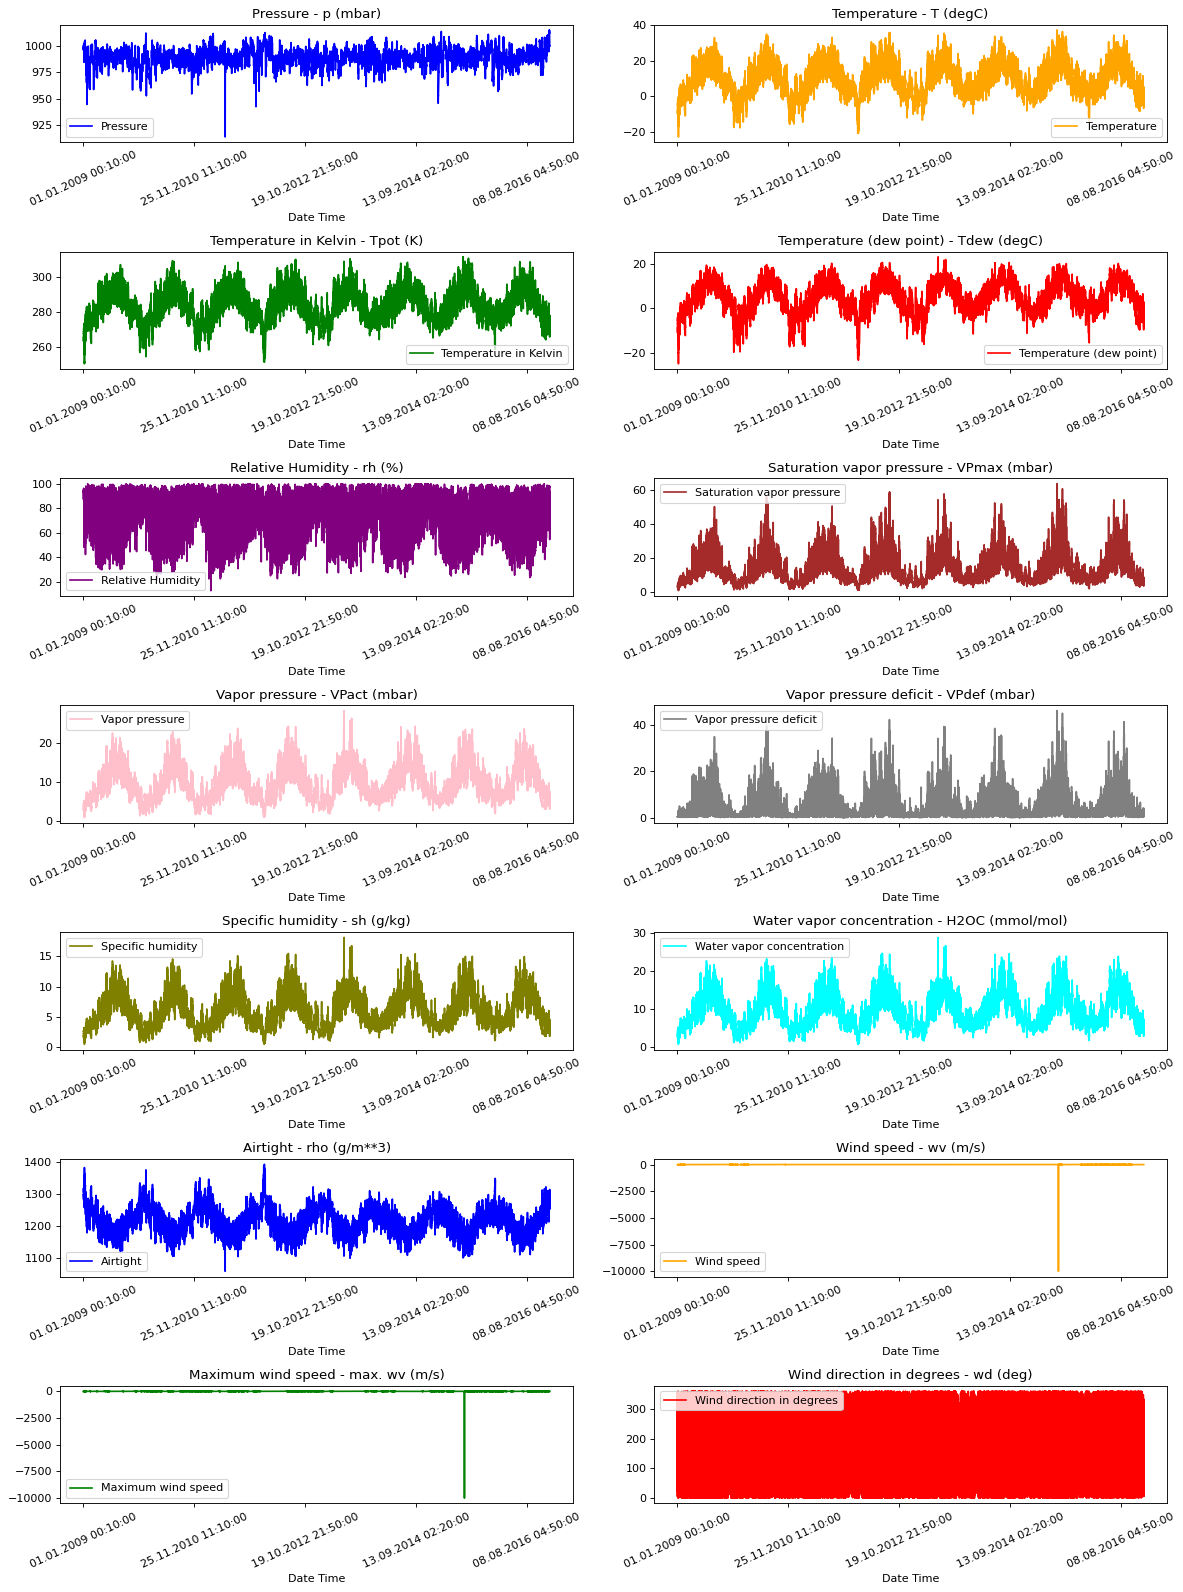

In [5]:
titles = [
    "Pressure",
    "Temperature",
    "Temperature in Kelvin",
    "Temperature (dew point)",
    "Relative Humidity",
    "Saturation vapor pressure",
    "Vapor pressure",
    "Vapor pressure deficit",
    "Specific humidity",
    "Water vapor concentration",
    "Airtight",
    "Wind speed",
    "Maximum wind speed",
    "Wind direction in degrees",
]

feature_keys = [
    "p (mbar)",
    "T (degC)",
    "Tpot (K)",
    "Tdew (degC)",
    "rh (%)",
    "VPmax (mbar)",
    "VPact (mbar)",
    "VPdef (mbar)",
    "sh (g/kg)",
    "H2OC (mmol/mol)",
    "rho (g/m**3)",
    "wv (m/s)",
    "max. wv (m/s)",
    "wd (deg)",
]

colors = [
    "blue",
    "orange",
    "green",
    "red",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
    "cyan",
]

date_time_key = "Date Time"

def show_raw_visualization(data):
    time_data = data[date_time_key]
    fig, axes = plt.subplots(
        nrows=7, ncols=2, figsize=(15, 20), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(len(feature_keys)):
        key = feature_keys[i]
        c = colors[i % (len(colors))]
        t_data = data[key]
        t_data.index = time_data
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color=c,
            title="{} - {}".format(titles[i], key),
            rot=25,
        )
        ax.legend([titles[i]])
    plt.tight_layout()


show_raw_visualization(df)

This heat map shows the correlation between different features.

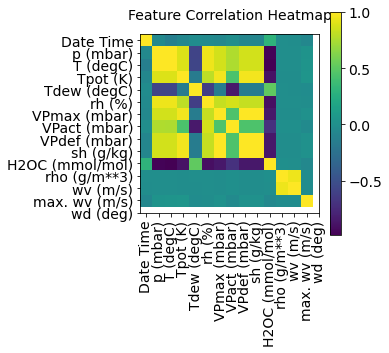

In [6]:
def show_heatmap(data):
    plt.matshow(data.corr())
    plt.xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=90)
    plt.gca().xaxis.tick_bottom()
    plt.yticks(range(data.shape[1]), data.columns, fontsize=14)

    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title("Feature Correlation Heatmap", fontsize=14)
    plt.show()

show_heatmap(df)

### Preprocess the dataset

Here we are picking ~300,000 data points for training. Observation is recorded every
10 mins, that means 6 times per hour. We will resample one point per hour since no
drastic change is expected within 60 minutes. We do this via the `sampling_rate`
argument in `timeseries_dataset_from_array` utility.

We are tracking data from past 720 timestamps (720/6=120 hours). This data will be
used to predict the temperature after 72 timestamps (72/6=12 hours).

Since every feature has values with
varying ranges, we do normalization to confine feature values to a range of `[0, 1]` before
training a neural network.
We do this by subtracting the mean and dividing by the standard deviation of each feature.

71.5 % of the data will be used to train the model, i.e. 300,693 rows. `split_fraction` can
be changed to alter this percentage.

The model is shown data for first 5 days i.e. 720 observations, that are sampled every
hour. The temperature after 72 (12 hours * 6 observation per hour) observation will be
used as a label.

In [7]:
split_fraction = 0.715
train_split = int(split_fraction * int(df.shape[0]))
step = 6

past = 720
future = 72
learning_rate = 0.001
batch_size = 256

def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std

We can see from the correlation heatmap, few parameters like Relative Humidity and
Specific Humidity are redundant. Hence we will be using select features, not all.

In [8]:
print(
    "The selected parameters are:",
    ", ".join([titles[i] for i in [0, 1, 5, 7, 8, 10, 11]]),
)
selected_features = [feature_keys[i] for i in [0, 1, 5, 7, 8, 10, 11]]
features = df[selected_features]
features.index = df[date_time_key]
features.head()

features = normalize(features.values, train_split)
features = pd.DataFrame(features)
features.head()

train_data = features.loc[0 : train_split - 1]
val_data = features.loc[train_split:]

The selected parameters are: Pressure, Temperature, Saturation vapor pressure, Vapor pressure deficit, Specific humidity, Airtight, Wind speed


### Split the training and validation dataset

The training dataset labels starts from the 792nd observation (720 + 72).

In [9]:
start = past + future
end = start + train_split

x_train = train_data[[i for i in range(7)]].values
y_train = features.iloc[start:end][[1]]
print('training size:', len(x_train))

sequence_length = int(past / step)
print('window size:', sequence_length)

training size: 300693
window size: 120


The `timeseries_dataset_from_array` function takes in a sequence of data-points gathered at
equal intervals, along with time series parameters such as length of the
sequences/windows, spacing between two sequence/windows, etc., to produce batches of
sub-timeseries inputs and targets sampled from the main time series.

In [10]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

The validation dataset must not contain the last 792 rows as we won't have label data for
those records, hence 792 must be subtracted from the end of the data.

The validation label dataset must start from 792 after train_split, hence we must add
past + future (792) to label_start.

In [11]:
x_end = len(val_data) - past - future

label_start = train_split + past + future

x_val = val_data.iloc[:x_end][[i for i in range(7)]].values
y_val = features.iloc[label_start:][[1]]

dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

for batch in dataset_train.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (256, 120, 7)
Target shape: (256, 1)


The input shape is the above-defined `batch_size`, the sequence length (120 hours), and the 7 selected features.

When we convert the model for the Edge TPU, we'll have to change this batch size to 1 for compiler compatibility.

## Build and train the LSTM model

In [12]:
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = keras.layers.LSTM(32)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss='mse')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 7)]          0         
                                                                 
 lstm (LSTM)                 (None, 32)                5120      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 5,153
Trainable params: 5,153
Non-trainable params: 0
_________________________________________________________________


We'll use the `ModelCheckpoint` callback to regularly save checkpoints, and
the `EarlyStopping` callback to interrupt training when the validation loss
is not longer improving.

In [13]:
epochs = 10

In [14]:
path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)

Epoch 1/10
1172/1172 [==============================] - ETA: 0s - loss: 0.1834
Epoch 1: val_loss improved from inf to 0.15799, saving model to model_checkpoint.h5
1172/1172 [==============================] - 62s 47ms/step - loss: 0.1834 - val_loss: 0.1580
Epoch 2/10
1172/1172 [==============================] - ETA: 0s - loss: 0.1245
Epoch 2: val_loss improved from 0.15799 to 0.13471, saving model to model_checkpoint.h5
1172/1172 [==============================] - 55s 47ms/step - loss: 0.1245 - val_loss: 0.1347
Epoch 3/10
1172/1172 [==============================] - ETA: 0s - loss: 0.1154
Epoch 3: val_loss improved from 0.13471 to 0.13456, saving model to model_checkpoint.h5
1172/1172 [==============================] - 56s 48ms/step - loss: 0.1154 - val_loss: 0.1346
Epoch 4/10
1172/1172 [==============================] - ETA: 0s - loss: 0.1109
Epoch 4: val_loss improved from 0.13456 to 0.13448, saving model to model_checkpoint.h5
1172/1172 [==============================] - 55s 47ms/ste

We can visualize the loss with the function below. After one point, the loss stops
decreasing.

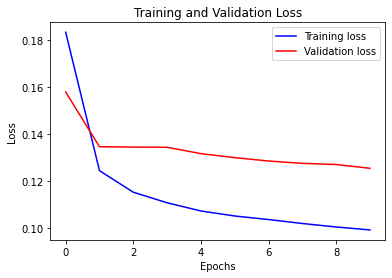

Final val loss:  [0.15799252688884735, 0.13470600545406342, 0.13455680012702942, 0.13447518646717072, 0.1317671537399292, 0.1300686150789261, 0.12862251698970795, 0.12763886153697968, 0.12714025378227234, 0.12553420662879944]


In [15]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    print("Final val loss: ", val_loss)

visualize_loss(history, "Training and Validation Loss")

## Plot some predictions

Now let's see what some of the predictions look like from a new test set. We create a new test dataset (even though it's has the same data as the validation set) because we want a batch size of just 1 (that's required when we compile for the Edge TPU). We also set the `sequence_stride` to something bigger than the sequence/window length, so our test samples aren't almost identical.

In [16]:
dataset_test = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    sequence_stride=int(sequence_length * 6),
    sampling_rate=step,
    batch_size=1,
)

1/1 [==============================] - 0s 368ms/step
prediction: [0.11748128]
truth: [0.2258011]


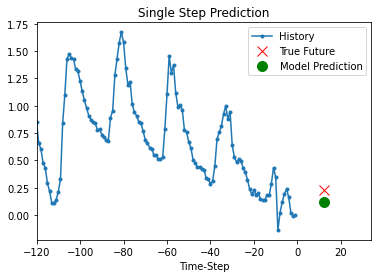

1/1 [==============================] - 0s 22ms/step
prediction: [0.35474053]
truth: [0.43425469]


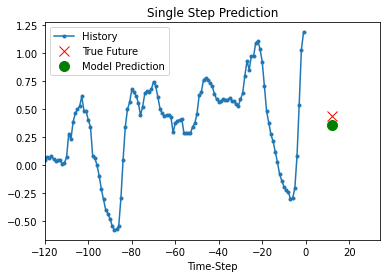

1/1 [==============================] - 0s 21ms/step
prediction: [0.50147563]
truth: [0.03356057]


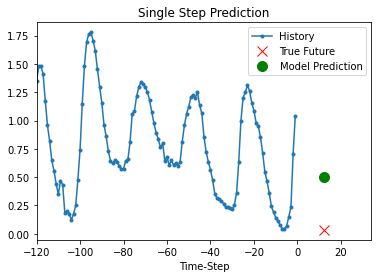

1/1 [==============================] - 0s 20ms/step
prediction: [0.3781033]
truth: [0.98434055]


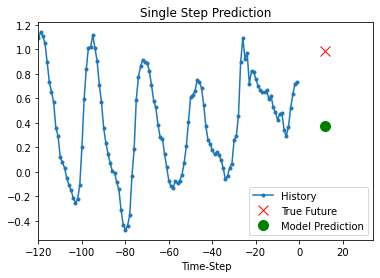

1/1 [==============================] - 0s 17ms/step
prediction: [0.5045234]
truth: [0.41109318]


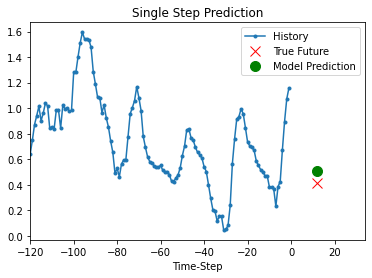

In [17]:
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return

for x, y in dataset_test.take(5):
    prediction = model.predict(x)
    prediction = prediction[0]
    print('prediction:', prediction)
    print('truth:', y[0].numpy())
    show_plot(
        [x[0][:, 1].numpy(), y[0], prediction],
        12,
        "Single Step Prediction",
    )

In [19]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM

In [20]:
print(tf.version.VERSION)

2.9.2


## Convert to TF Lite

In [22]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS] 
converter._experimental_lower_tensor_list_ops = False
#tflite_model = converter.convert()
tflite_model = converter.convert()

with open('weather_forecast.tflite', 'wb') as f:
  f.write(tflite_model)

That gives us a basic TF Lite version, which can be useful for benchmarks, but we need it fully-quantized for compatibility with the Edge TPU...

### Create quantized version

First, we need to update the model's input shape to a fixed size, as dictated by the [Edge TPU model requirements](https://coral.ai/docs/edgetpu/models-intro/#model-requirements).

In [23]:
batch_size = 1
model.input.set_shape((batch_size,) + model.input.shape[1:])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(1, 120, 7)]             0         
                                                                 
 lstm (LSTM)                 (None, 32)                5120      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 5,153
Trainable params: 5,153
Non-trainable params: 0
_________________________________________________________________


In [24]:
# Our representative dataset is the same as the training dataset,
# but the batch size must now be 1
dataset_repr = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

def representative_data_gen():
  # To ensure full coverage of possible inputs, we use the whole train set
  for input_data, _ in dataset_repr.take(int(len(x_train))):
    input_data = tf.cast(input_data, dtype=tf.float32)
    yield [input_data]

This part takes several minutes due to the size of the representative dataset:

In [25]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
# This enables quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# This sets the representative dataset for quantization
converter.representative_dataset = representative_data_gen
# This ensures that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# For full integer quantization, though supported types defaults to int8 only, we explicitly declare it for clarity
converter.target_spec.supported_types = [tf.int8]
# These set the input and output tensors to int8
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8
tflite_model_quant = converter.convert()

with open('weather_forecast_quant.tflite', 'wb') as f:
  f.write(tflite_model_quant)

/usr/local/lib/python3.7/dist-packages/tensorflow/lite/python/convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


### Try some TF Lite predictions

prediction: [0.08501387]
truth: [0.2258011]


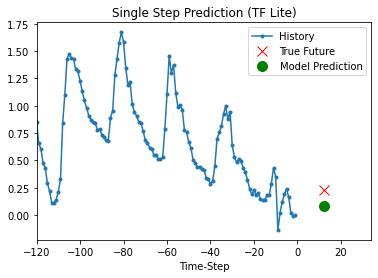

prediction: [0.27629509]
truth: [0.43425469]


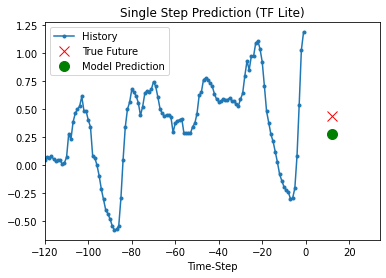

prediction: [0.42506937]
truth: [0.03356057]


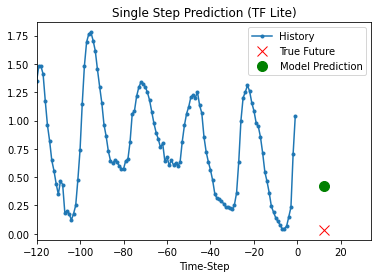

prediction: [0.29754856]
truth: [0.98434055]


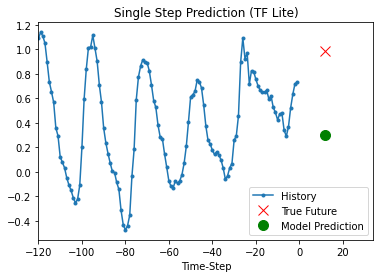

prediction: [0.44632284]
truth: [0.41109318]


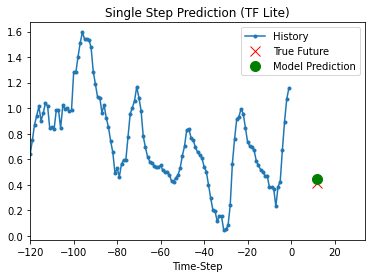

In [26]:
import numpy as np

def set_input_tensor(interpreter, input):
  input_details = interpreter.get_input_details()[0]
  tensor_index = input_details['index']
  input_tensor = interpreter.tensor(tensor_index)()
  # Inputs for the TFLite model must be uint8, so we quantize our input data.
  scale, zero_point = input_details['quantization']
  quantized_input = np.uint8(input / scale + zero_point)
  input_tensor[:, :, :] = quantized_input

def predict_weather(interpreter, input):
  set_input_tensor(interpreter, input)
  interpreter.invoke()
  output_details = interpreter.get_output_details()[0]
  output = interpreter.get_tensor(output_details['index'])
  # Outputs from the TFLite model are uint8, so we dequantize the results:
  scale, zero_point = output_details['quantization']
  output = scale * (output - zero_point)
  return output

interpreter = tf.lite.Interpreter('weather_forecast_quant.tflite')
interpreter.allocate_tensors()

for x, y in dataset_test.take(5):
  prediction = predict_weather(interpreter, x)
  print('prediction:', prediction[0])
  print('truth:', y[0].numpy())

  show_plot(
      [x[0][:, 1].numpy(), y[0], prediction[0]],
      12,
      "Single Step Prediction (TF Lite)",
  )

If you compare these predictions from the quantized model to those we got from the float Keras model above, they're not very different.

## Compile for the Arduino Nano 33 BLE

In [27]:
!echo "const unsigned char model[] = {" > /content/model.h
!cat weather_forecast_quant.tflite | xxd -i      >> /content/model.h
!echo "};"                              >> /content/model.h

import os
model_h_size = os.path.getsize("model.h")
print(f"Header file, model.h, is {model_h_size:,} bytes.")
print("\nOpen the side panel (refresh if needed). Double click model.h to download the file.")

Header file, model.h, is 61,010 bytes.

Open the side panel (refresh if needed). Double click model.h to download the file.


You can find the compiled model in the **Files** window on the left, named `weather_forecast_quant.tflite`.